In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.data import DataManager
from src.utils import load_model
from scipy.spatial.distance import cdist
import seaborn as sns
import warnings

In [2]:
def find_most_typical_series(X: np.ndarray) -> np.ndarray:
    n_samples, n_features, n_timesteps = X.shape

    if n_samples == 0:
        raise ValueError("The dataset must not be empty.")
    if n_samples == 1:
        return X[0]

    X_flat = X.reshape(n_samples, -1)  # (n_samples, n_features * n_timesteps)
    distances_matrix = cdist(X_flat, X_flat, metric="euclidean")
    sum_of_distances = np.sum(distances_matrix, axis=1)
    most_typical_idx = np.argmin(sum_of_distances)

    return X[most_typical_idx]


def plot_samples(
    X: np.ndarray,
    y: np.ndarray,
    n_cols: int = 3,
    show_typical: bool = True,
    alpha: float = 0.15,
    linewidth_individual: float = 0.8,
    figsize_per_subplot: tuple = (5, 4),
    title: str = "Time Series Visualization by Class",
    save_path: str = None,
    dpi: int = 300,
    show_stats: bool = True,
    color_palette: str = "husl",
):
    plt.style.use("default")
    sns.set_palette(color_palette)
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
            "axes.grid": True,
            "grid.alpha": 0.3,
            "axes.spines.top": False,
            "axes.spines.right": False,
            "axes.linewidth": 1.2,
            "xtick.direction": "out",
            "ytick.direction": "out",
        }
    )

    unique_labels = np.unique(y)
    n_labels = len(unique_labels)

    if n_cols is None or n_cols <= 0:
        n_cols_actual = min(3, n_labels)
    else:
        n_cols_actual = min(n_cols, n_labels)

    n_rows = int(np.ceil(n_labels / n_cols_actual))

    fig_width = figsize_per_subplot[0] * n_cols_actual
    fig_height = figsize_per_subplot[1] * n_rows

    fig, axes = plt.subplots(
        n_rows,
        n_cols_actual,
        figsize=(fig_width, fig_height),
        squeeze=False,
        facecolor="white",
    )
    axes = axes.flatten()

    colors = sns.color_palette(color_palette, n_labels)

    stats_info = []

    for i, label in enumerate(unique_labels):
        ax = axes[i]
        samples_with_label = X[y == label]
        current_color = colors[i]
        n_samples = len(samples_with_label)

        if n_samples > 0:
            first_sample = samples_with_label[0]

            if first_sample.ndim == 1:
                for sample in samples_with_label:
                    ax.plot(
                        sample.T,
                        alpha=alpha,
                        color=current_color,
                        linewidth=linewidth_individual,
                        rasterized=True,
                    )
            elif first_sample.ndim == 2:
                for sample in samples_with_label:
                    for feature_idx, feature_series in enumerate(sample):
                        ax.plot(
                            feature_series.T,
                            alpha=alpha,
                            color=current_color,
                            linewidth=linewidth_individual,
                            rasterized=True,
                        )
            else:
                warnings.warn(
                    f"Unexpected format for class {label}. Dim: {first_sample.ndim}"
                )
                continue

        if show_typical and n_samples > 0:
            try:
                typical_series = find_most_typical_series(samples_with_label)

                if typical_series.ndim == 1:
                    ax.plot(
                        typical_series.T,
                        color="white",
                        linewidth=4,
                        linestyle="-",
                        alpha=0.8,
                        zorder=10,
                    )
                    ax.plot(
                        typical_series.T,
                        color=current_color,
                        linewidth=2.5,
                        linestyle="-",
                        label="Typical series",
                        zorder=11,
                    )
                elif typical_series.ndim == 2:
                    for feature_idx, feature_series in enumerate(typical_series):
                        ax.plot(
                            feature_series.T,
                            color="white",
                            linewidth=4,
                            linestyle="-",
                            alpha=0.8,
                            zorder=10,
                        )
                        ax.plot(
                            feature_series.T,
                            color=current_color,
                            linewidth=2.5,
                            linestyle="-",
                            zorder=11,
                        )
            except Exception as e:
                warnings.warn(
                    f"Could not calculate typical series for class {label}: {e}"
                )

        ax.set_title(
            f"Class {label}", fontsize=14, fontweight="bold", pad=15, color="#2C3E50"
        )
        ax.set_xlabel("Time", fontsize=11, color="#34495E")
        ax.set_ylabel("Value", fontsize=11, color="#34495E")

        ax.grid(True, linestyle=":", alpha=0.4, color="#BDC3C7")
        ax.tick_params(axis="both", which="major", labelsize=9, colors="#5D6D7E")

        if show_stats:
            info_text = f"n = {n_samples}"
            if n_samples > 0:
                if first_sample.ndim == 1:
                    mean_val = np.mean(samples_with_label)
                    std_val = np.std(samples_with_label)
                    info_text += f"\nμ = {mean_val:.2f}\nσ = {std_val:.2f}"

            ax.text(
                0.02,
                0.98,
                info_text,
                transform=ax.transAxes,
                fontsize=9,
                verticalalignment="top",
                horizontalalignment="left",
                bbox=dict(
                    boxstyle="round,pad=0.3",
                    facecolor=current_color,
                    alpha=0.1,
                    edgecolor="none",
                ),
                color="#2C3E50",
            )

        ax.margins(x=0.02, y=0.05)

        for spine in ax.spines.values():
            spine.set_color("#BDC3C7")
            spine.set_linewidth(1)

        stats_info.append(f"Class {label}: {n_samples} samples")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    if title:
        fig.suptitle(title, fontsize=16, fontweight="bold", y=0.98, color="#2C3E50")

    if show_stats:
        stats_text = f"Total classes: {n_labels} | Total samples: {len(y)}"
        fig.text(
            0.5,
            0.02,
            stats_text,
            ha="center",
            va="bottom",
            fontsize=10,
            color="#5D6D7E",
            style="italic",
        )

    plt.tight_layout(rect=[0, 0.04, 1, 0.96])

    if save_path:
        plt.savefig(
            save_path, dpi=dpi, bbox_inches="tight", facecolor="white", edgecolor="none"
        )
        print(f"Plot saved at: {save_path}")

    plt.show()

In [3]:
dataset = "chinatown"
model = load_model(dataset, "fcn")
chinatown_data = DataManager(f"./UCR/{dataset}", model, "standard")
X_train0 = np.asarray(chinatown_data.X_train)
y_train0 = np.asarray(chinatown_data.y_train_true)
X_test0 = np.asarray(chinatown_data.X_test)
y_test0 = np.asarray(chinatown_data.y_test_true)

X0 = np.concatenate((X_train0, X_test0), axis=0)
y0 = np.concatenate((y_train0, y_test0), axis=0)

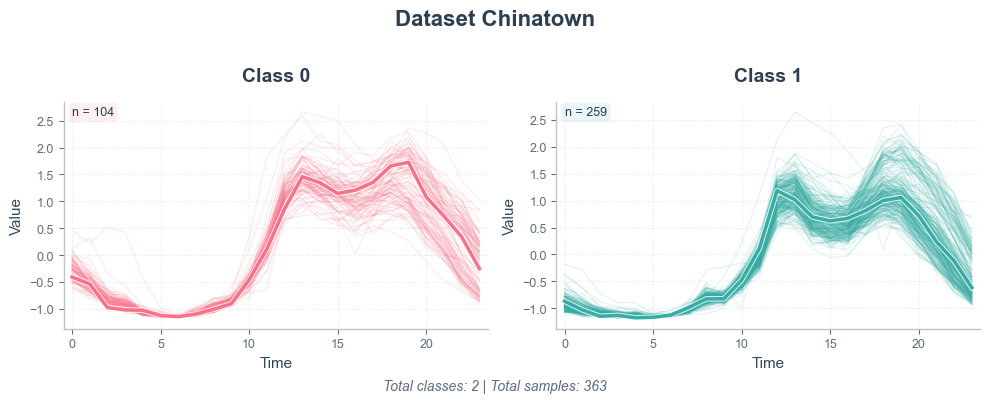

In [4]:
plot_samples(X0, y0, title=f"Dataset {dataset.capitalize()}")

In [5]:
dataset = "ecg200"
model = load_model(dataset, "fcn")
chinatown_data = DataManager(f"./UCR/{dataset}", model, "standard")
X_train1 = np.asarray(chinatown_data.X_train)
y_train1 = np.asarray(chinatown_data.y_train_true)
X_test1 = np.asarray(chinatown_data.X_test)
y_test1 = np.asarray(chinatown_data.y_test_true)

X1 = np.concatenate((X_train1, X_test1), axis=0)
y1 = np.concatenate((y_train1, y_test1), axis=0)

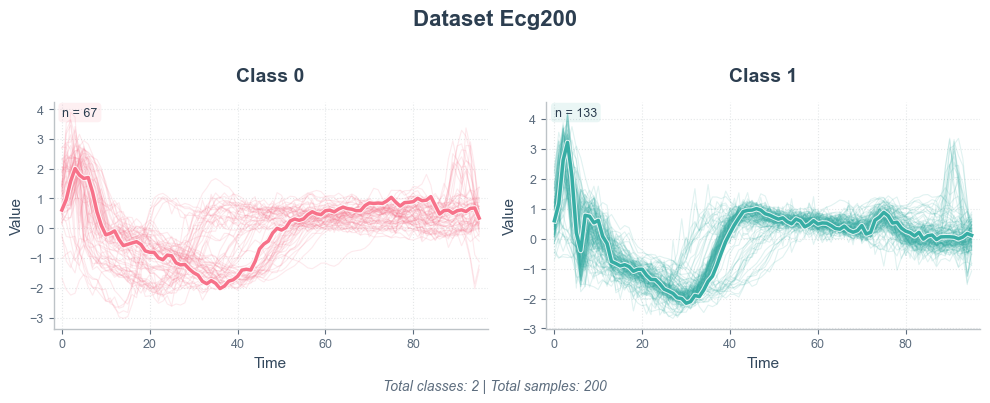

In [6]:
plot_samples(X1, y1, title=f"Dataset {dataset.capitalize()}")

In [7]:
dataset = "forda"
model = load_model(dataset, "fcn")
chinatown_data = DataManager(f"./UCR/{dataset}", model, "standard")
X_train2 = np.asarray(chinatown_data.X_train)
y_train2 = np.asarray(chinatown_data.y_train_true)
X_test2 = np.asarray(chinatown_data.X_test)
y_test2 = np.asarray(chinatown_data.y_test_true)

X2 = np.concatenate((X_train2, X_test2), axis=0)
y2 = np.concatenate((y_train2, y_test2), axis=0)

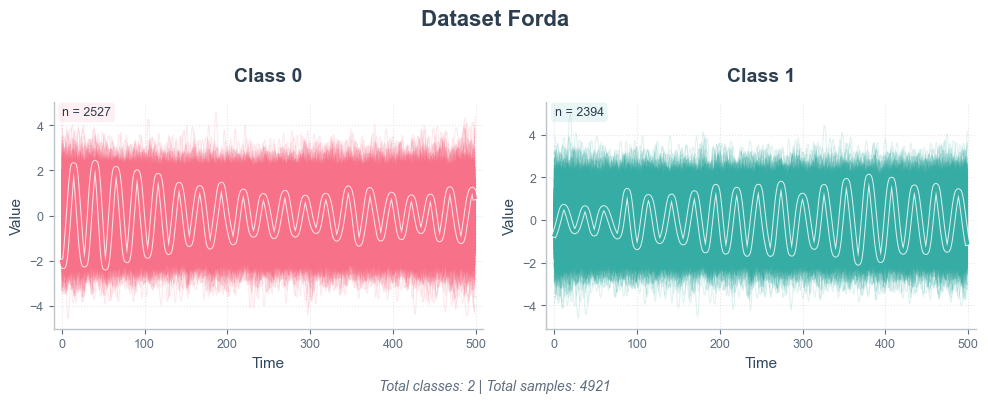

In [8]:
plot_samples(X2, y2, show_typical=True, title=f"Dataset {dataset.capitalize()}")

In [9]:
dataset = "gunpoint"
model = load_model(dataset, "fcn")
chinatown_data = DataManager(f"./UCR/{dataset}", model, "standard")
X_train3 = np.asarray(chinatown_data.X_train)
y_train3 = np.asarray(chinatown_data.y_train_true)
X_test3 = np.asarray(chinatown_data.X_test)
y_test3 = np.asarray(chinatown_data.y_test_true)

X3 = np.concatenate((X_train3, X_test3), axis=0)
y3 = np.concatenate((y_train3, y_test3), axis=0)

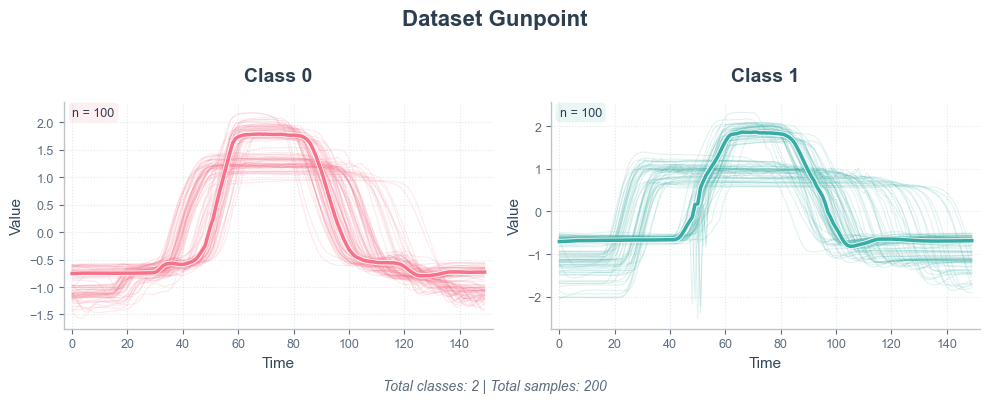

In [10]:
plot_samples(X3, y3, title=f"Dataset {dataset.capitalize()}")

In [11]:
dataset = "beef"
model = load_model(dataset, "fcn")
chinatown_data = DataManager(f"./UCR/{dataset}", model, "standard")
X_train4 = np.asarray(chinatown_data.X_train)
y_train4 = np.asarray(chinatown_data.y_train_true)
X_test4 = np.asarray(chinatown_data.X_test)
y_test4 = np.asarray(chinatown_data.y_test_true)

X4 = np.concatenate((X_train4, X_test4), axis=0)
y4 = np.concatenate((y_train4, y_test4), axis=0)

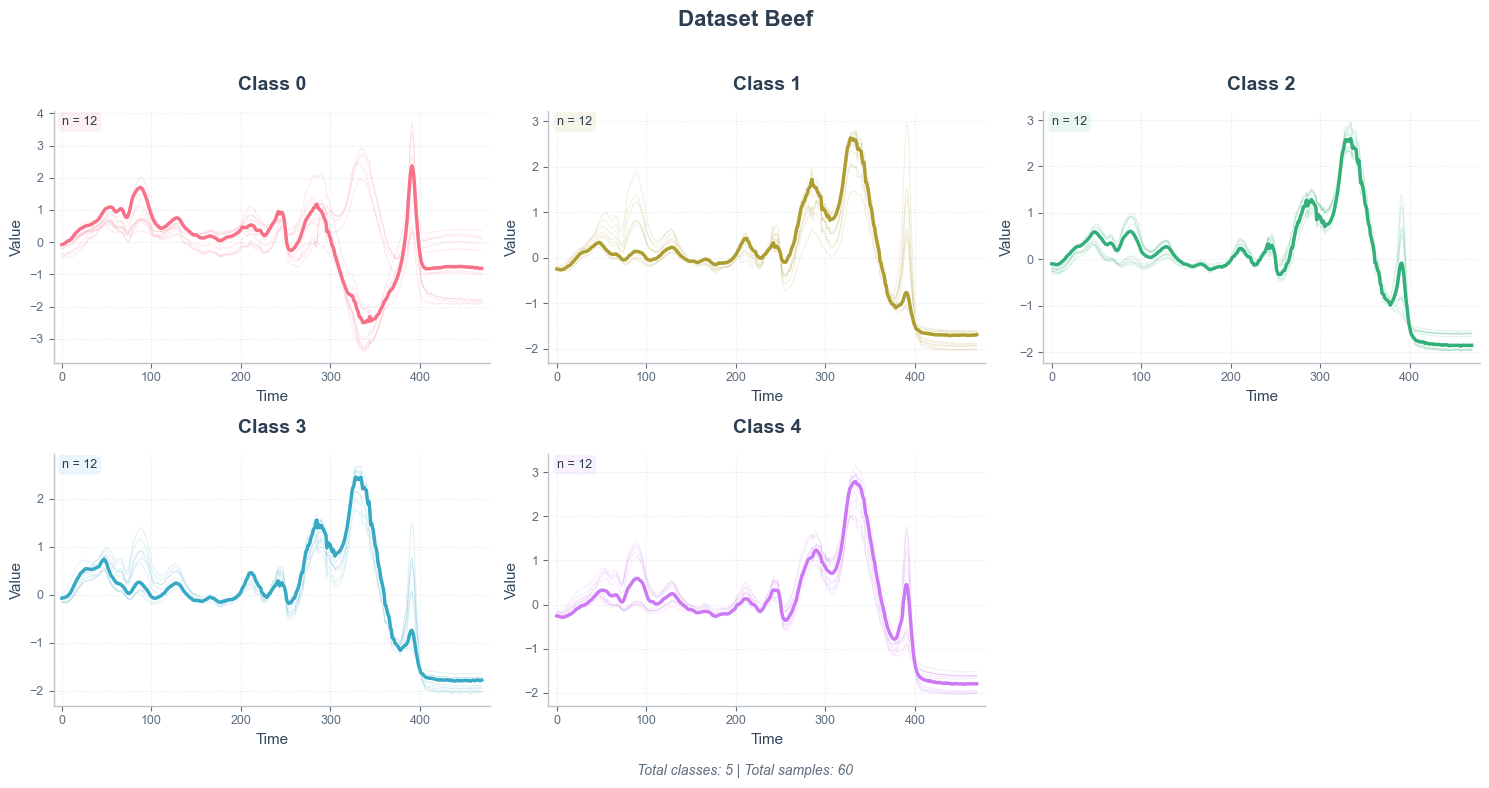

In [12]:
plot_samples(X4, y4, title=f"Dataset {dataset.capitalize()}")